# GPR to predict the number of atoms


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline
from sklearn.model_selection import train_test_split
from scipy.signal import savgol_filter
from sklearn.metrics import r2_score
import sklearn.gaussian_process as gp

In [2]:
df = pd.read_csv('mu_cn10000.csv')


In [3]:
def GPR_get_CN(features, labels, percent_test):
    # Split the data into training and testing sets
    train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size=percent_test, random_state = 42)
    # Import the model we are using
    kernel = gp.kernels.ConstantKernel(1.0, (1e-1, 1e3)) * gp.kernels.RBF(10.0, (1e-3, 1e3))
    model = gp.GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=0.1, normalize_y=True)
    gpr = model.fit(train_features, train_labels)
    params = model.kernel_.get_params()
    pred_labels, std = model.predict(test_features, return_std=True)
    MSE = ((pred_labels-test_labels)**2).mean()
    RMSE = MSE**(1/2)
    print('MSE = ', MSE)
    print('RMSE =', RMSE)
    rSquare = r2_score(test_labels, pred_labels)
    print('R Squared Error:', rSquare)
    return (RMSE, rSquare)

In [15]:
def xanes_derivatives(mu_df, dx=0.80808080808):
    '''
    xanes_derivatives calculates and returns the first and second derivative of a series of XANES spectra.
    Inputs:
        mu_df = Pandas dataframe of averaged XANES spectra absorption values.
        dx = distance between uniformly distributed energy values in XANES spectra. Defaulted to value provided in data.
    '''
    for nums in range(len(mu_df)):
        if nums == 0:
            pass

    dmu1 = np.zeros([len(mu_df), len(mu_df.columns)])
    dmu2 = np.zeros([len(mu_df), len(mu_df.columns)])
    if len(mu_df.columns) == 1000:
        dx =0.1*dx

    for i in range(len(mu_df)):
        for j in range(len(mu_df.columns)):
            if j == len(mu_df.columns)-1:
                pass
            else:
                dmu1[i, j] = (mu_df.iloc[i, j+1] - mu_df.iloc[i, j]) / dx

    for i_ in range(len(mu_df)):
        for j_ in range(len(mu_df.columns)):
            if j_ == len(mu_df.columns)-1:
                pass
            else:
                dmu2[i_, j_] = (dmu1[i_, j_+1] - dmu1[i_, j_]) / dx

    return dmu1, dmu2

In [16]:
def raw_spectra(df):

    features=np.array(df.loc[:,'Mu1':'Mu100'])
    
    return features

In [17]:
def one_demension_get_N_evenly_spaced_elements(arr, numElems):
    '''
    return nd.array
    '''
    idx = np.round(np.linspace(0, len(arr) - 1, numElems)).astype(int)
    return arr[idx]

In [18]:
def ndArray_get_N_evely_spaced_elements(after_smooth, numElems):
    ndArray_evenly_spaced=np.array([])
    for arr in after_smooth:
        a_row_evenly_spaced=one_demension_get_N_evenly_spaced_elements(arr, numElems)
        print(a_row_evenly_spaced)
        #ndArray_evenly_spaced=np.concatenate((ndArray_evenly_spaced, [a_row_evenly_spaced]),axis=0)
        ndArray_evenly_spaced  = np.append(ndArray_evenly_spaced, a_row_evenly_spaced, axis=0)
    return ndArray_evenly_spaced.reshape(len(after_smooth),numElems)

In [25]:
def setSize_vs_error (size, size_list, df):
    spectrum_data = []
    dmu1_data = []
    dmu2_data = []
    dmu_both_data = []
    for entry in size_list:
        df_sample = df.sample(size, random_state=26)
        raw_df_sample = raw_spectra(df_sample)
        dmu1, dmu2 =xanes_derivatives(pd.DataFrame(raw_df_sample))
        dmu_both= np.concatenate((dmu1,dmu2),axis=1)
        print('percent test =', entry)
        print('spectrum')
        spectrum_data.append(GPR_get_CN(raw_df_sample, np.array(df_sample['CN']), entry))
        print('dmu1')
        dmu1_data.append(GPR_get_CN(dmu1, np.array(df_sample['CN']), entry))        
        print('dmu2')
        dmu2_data.append(GPR_get_CN(dmu2, np.array(df_sample['CN']), entry))
        print('dmu_both')
        dmu_both_data.append(GPR_get_CN(dmu_both, np.array(df_sample['CN']), entry))

    return (spectrum_data, dmu1_data, dmu2_data, dmu_both_data)

In [4]:
def derivatives(X_smooth, x_axis):
    '''
    derivatives returns the first, second, and combined first and second derivitive dataframes after smoothing
    '''
    dmu1 = np.zeros([np.shape(X_smooth)[0], np.shape(X_smooth)[1]-1])
    dmu2 = np.zeros([np.shape(X_smooth)[0], np.shape(X_smooth)[1]-2])
    dx = x_axis[1] - x_axis[0]
    for i in range(np.shape(X_smooth)[0]):
        for j in range(np.shape(dmu1)[1]):
            dmu1[i, j] = (X_smooth.iloc[i, j+1] - X_smooth.iloc[i, j]) / dx


    for i in range(np.shape(X_smooth)[0]):
        for j in range(np.shape(dmu2)[1]):
            dmu2[i, j] = (dmu1[i, j+1] - dmu1[i, j]) / dx
    
    df1 = pd.DataFrame(dmu1)
    df2 = pd.DataFrame(dmu2)
    df3 = pd.concat([df1, df2], axis=1)

    return df1, df2, df3

In [5]:
X = df.drop(labels=['CN', 'Num Cu', 'Num Te'], axis=1)

xs = np.linspace(8970, 9050, 1000)
energies = np.linspace(8970, 9050, 100)

X_1000 = np.empty([10000,1000])
for i in range(X.shape[0]):
    s1 = UnivariateSpline(energies, X.loc[i], s=0)
    y1 = s1(xs) # generate a line with 1000 data
    X_1000[i] = y1
X_1000 = pd.DataFrame(X_1000)
y = df[['CN']]

In [6]:
df1, df2, df3 = derivatives(X_1000, xs)

In [19]:
size_list = [0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]
for entry in size_list:
    print(entry)
    GPR_get_CN(X_1000, y, entry)
    print()

0.9
MSE =  CN    0.002632
dtype: float64
RMSE = CN    0.051301
dtype: float64
R Squared Error: 0.986258289977784

0.8
MSE =  CN    0.001833
dtype: float64
RMSE = CN    0.04281
dtype: float64
R Squared Error: 0.9904835974896185

0.7
MSE =  CN    0.001481
dtype: float64
RMSE = CN    0.038482
dtype: float64
R Squared Error: 0.992328291539023

0.6
MSE =  CN    0.001263
dtype: float64
RMSE = CN    0.035543
dtype: float64
R Squared Error: 0.9934134312719107

0.5
MSE =  CN    0.001083
dtype: float64
RMSE = CN    0.032915
dtype: float64
R Squared Error: 0.9944179387867282

0.4
MSE =  CN    0.001002
dtype: float64
RMSE = CN    0.031655
dtype: float64
R Squared Error: 0.9948287968355571

0.3
MSE =  CN    0.000924
dtype: float64
RMSE = CN    0.03039
dtype: float64
R Squared Error: 0.9952029458440723

0.2
MSE =  CN    0.000849
dtype: float64
RMSE = CN    0.029134
dtype: float64
R Squared Error: 0.9955712749209173

0.1
MSE =  CN    0.000801
dtype: float64
RMSE = CN    0.028303
dtype: float64
R Squa

In [21]:
for entry in size_list:
    print(entry)
    GPR_get_CN(df1, y, entry)
    print()

0.9
MSE =  CN    0.001645
dtype: float64
RMSE = CN    0.040561
dtype: float64
R Squared Error: 0.991409640499966

0.8
MSE =  CN    0.001077
dtype: float64
RMSE = CN    0.032811
dtype: float64
R Squared Error: 0.9944098503130887

0.7
MSE =  CN    0.000907
dtype: float64
RMSE = CN    0.030122
dtype: float64
R Squared Error: 0.9952994003711444

0.6
MSE =  CN    0.000823
dtype: float64
RMSE = CN    0.028688
dtype: float64
R Squared Error: 0.9957090940399326

0.5
MSE =  CN    0.000765
dtype: float64
RMSE = CN    0.027662
dtype: float64
R Squared Error: 0.9960575572325517

0.4
MSE =  CN    0.00074
dtype: float64
RMSE = CN    0.027212
dtype: float64
R Squared Error: 0.9961785484577734

0.3
MSE =  CN    0.000705
dtype: float64
RMSE = CN    0.026555
dtype: float64
R Squared Error: 0.9963371844893519

0.2


/home/jpothoof/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


MSE =  CN    0.000691
dtype: float64
RMSE = CN    0.02628
dtype: float64
R Squared Error: 0.9963965724440909

0.1
MSE =  CN    0.000691
dtype: float64
RMSE = CN    0.02628
dtype: float64
R Squared Error: 0.996289101039623



In [8]:
size_list = [0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]
for entry in size_list:
    print(entry)
    GPR_get_CN(df2, y, entry)
    print()

0.9
MSE =  CN    0.002327
dtype: float64
RMSE = CN    0.048237
dtype: float64
R Squared Error: 0.9878508823917556

0.8
MSE =  CN    0.001385
dtype: float64
RMSE = CN    0.037212
dtype: float64
R Squared Error: 0.9928098010335344

0.7
MSE =  CN    0.001039
dtype: float64
RMSE = CN    0.03223
dtype: float64
R Squared Error: 0.9946184405409206

0.6
MSE =  CN    0.000856
dtype: float64
RMSE = CN    0.029252
dtype: float64
R Squared Error: 0.9955385166011148

0.5


/home/jpothoof/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-4.13479452e+00,  2.14143064e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 55, 'nit': 13, 'warnflag': 2}
  ConvergenceWarning)


MSE =  CN    0.000763
dtype: float64
RMSE = CN    0.027631
dtype: float64
R Squared Error: 0.9960664113182867

0.4
MSE =  CN    0.000694
dtype: float64
RMSE = CN    0.026336
dtype: float64
R Squared Error: 0.9964204805818428

0.3
MSE =  CN    0.000628
dtype: float64
RMSE = CN    0.025052
dtype: float64
R Squared Error: 0.9967400942085917

0.2
MSE =  CN    0.000602
dtype: float64
RMSE = CN    0.024533
dtype: float64
R Squared Error: 0.996859569284186

0.1
MSE =  CN    0.000578
dtype: float64
RMSE = CN    0.02405
dtype: float64
R Squared Error: 0.9968922305826192



In [9]:
size_list = [0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1] 
for entry in size_list:
    print(entry)
    GPR_get_CN(df3, y, entry)
    print()

0.9
MSE =  CN    0.001571
dtype: float64
RMSE = CN    0.039638
dtype: float64
R Squared Error: 0.9917961136235818

0.8
MSE =  CN    0.001015
dtype: float64
RMSE = CN    0.031859
dtype: float64
R Squared Error: 0.9947295262625819

0.7
MSE =  CN    0.000839
dtype: float64
RMSE = CN    0.028974
dtype: float64
R Squared Error: 0.9956510069466752

0.6
MSE =  CN    0.000745
dtype: float64
RMSE = CN    0.027296
dtype: float64
R Squared Error: 0.9961152219204875

0.5
MSE =  CN    0.000689
dtype: float64
RMSE = CN    0.026249
dtype: float64
R Squared Error: 0.9964501483936371

0.4
MSE =  CN    0.000656
dtype: float64
RMSE = CN    0.025621
dtype: float64
R Squared Error: 0.99661220370367

0.3
MSE =  CN    0.000619
dtype: float64
RMSE = CN    0.024887
dtype: float64
R Squared Error: 0.996783059324858

0.2
MSE =  CN    0.000604
dtype: float64
RMSE = CN    0.024569
dtype: float64
R Squared Error: 0.9968504244447691

0.1
MSE =  CN    0.000605
dtype: float64
RMSE = CN    0.024599
dtype: float64
R Squ

In [16]:
spectrum_data = [(0.051301, 0.986258289977784), (0.04281, 0.9904835974896185), 
                 (0.038482, 0.992328291539023), (0.035543, 0.9934134312719107), 
                 (0.032915, 0.9944179387867282), (0.031655, 0.9948287968355571), 
                 (0.03039, 0.9952029458440723), (0.029134, 0.9955712749209173),
                 (0.028303, 0.9956957248876399)]

dmu1_data = [(0.040561, 0.991409640499966), (0.032811, 0.9944098503130887), 
                 (0.030122, 0.9952994003711444), (0.028688, 0.9957090940399326), 
                 (0.027662, 0.9960575572325517), (0.027212, 0.9961785484577734), 
                 (0.026555, 0.9963371844893519), (0.02628, 0.9963965724440909),
                 (0.02628, 0.996289101039623)]

dmu2_data = [(0.048237, 0.9878508823917556), (0.037212, 0.9928098010335344), 
                 (0.03223, 0.9946184405409206), (0.029252, 0.9955385166011148), 
                 (0.027631, 0.9960664113182867), (0.026336, 0.9964204805818428), 
                 (0.025052, 0.9967400942085917), (0.024533, 0.996859569284186),
                 (0.02405, 0.9968922305826192)]

dmu_both_data = [(0.039638, 0.9917961136235818),(0.031859, 0.9947295262625819), 
                 (0.028974, 0.9956510069466752), (0.027296, 0.9961152219204875), 
                 (0.026249, 0.9964501483936371), (0.025621, 0.99661220370367), 
                 (0.024887, 0.996783059324858), (0.024569, 0.9968504244447691),
                 (0.024599, 0.9967486349150907)]


In [17]:
spectrum_RMSE = []
spectrum_R2 = []
for entry in spectrum_data:
    spectrum_RMSE.append(entry[0])
    spectrum_R2.append(entry[1])
    
dmu1_RMSE = []
dmu1_R2 = []
for entry in dmu1_data:
    dmu1_RMSE.append(entry[0])
    dmu1_R2.append(entry[1])
    
dmu2_RMSE = []
dmu2_R2 = []
for entry in dmu2_data:
    dmu2_RMSE.append(entry[0])
    dmu2_R2.append(entry[1])
    
dmu_both_RMSE = []
dmu_both_R2 = []
for entry in dmu_both_data:
    dmu_both_RMSE.append(entry[0])
    dmu_both_R2.append(entry[1])

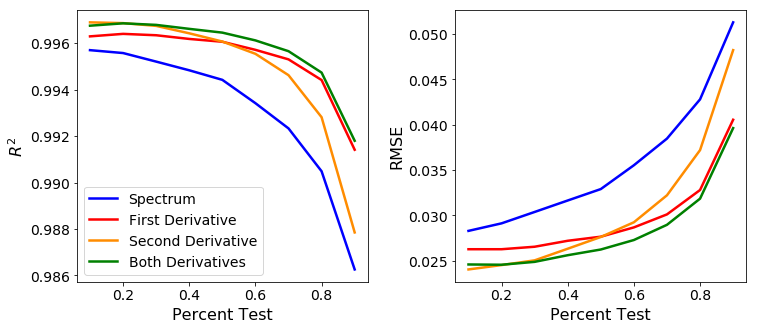

In [18]:
plt.rcParams.update({'font.size': 14})
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[12,5])
plt.subplots_adjust(wspace=0.3)
ax1.plot(size_list, spectrum_R2, c='blue', lw=2.5, label='Spectrum')
ax1.plot(size_list, dmu1_R2, c='red', lw=2.5, label='First Derivative')
ax1.plot(size_list, dmu2_R2, c='darkorange', lw=2.5, label='Second Derivative')
ax1.plot(size_list, dmu_both_R2, c='green', lw=2.5, label='Both Derivatives')
ax1.set_xlabel('Percent Test', fontsize=16)
ax1.set_ylabel('$R^2$', fontsize=16)
ax2.plot(size_list, spectrum_RMSE, c='blue', lw=2.5)
ax2.plot(size_list, dmu1_RMSE, c='red', lw=2.5)
ax2.plot(size_list, dmu2_RMSE, c='darkorange', lw=2.5)
ax2.plot(size_list, dmu_both_RMSE, c='green', lw=2.5)
ax2.set_xlabel('Percent Test', fontsize=16)
ax2.set_ylabel('RMSE', fontsize=16)
ax1.legend()
plt.show()